In [1]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans

from scipy import stats

from jupyterthemes import jtplot
jtplot.style(grid=False)

from wrangle_zillow import wrangle_zillow, scale_data, split_zillow
from FE_cluster import select_kbest, rfe
from sklearn.metrics import mean_squared_error
from IPython import display

# Analyzing and predicting logerror
- Project examining drivers of Zestimate logerror using the Zillow database from Codeup
- Goals are to find drivers of logerror, cluster the data into relevant groups, and to predict logerror using a machine learning model for each cluste

### Key Findings:
- logerror ranges from -4.7 to 3.4
- No linear correlation to logerror
- Region based clusters seems most logical

## Data acquisition and prep
- Data pulled from codeup zillow database
- Data is subset from "single unit" properties sold in 2017 from LA, Ventura, and Orange counties in Southern California
- Columns/Rows with > 70% nulls and duplicates were dropped
- nulls in buildingqualitytypeid and lotsizesquarefeet were filled with median values
- Zipcodes were erroneous so column was dropped
- County column created using fips
- Outliers based on tax_value were handled using 1.5x IQR upper and lower bound
- Home age(age_in_years) and Absolute logerror(logerror_absolute) columns created for use in exploration

In [2]:
#acquiring data from codeup zillow database
df = wrangle_zillow()
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 66858 entries, 0 to 77379
Data columns (total 30 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   parcelid                    66858 non-null  int64  
 1   logerror                    66858 non-null  float64
 2   transactiondate             66858 non-null  object 
 3   bathrooms                   66858 non-null  float64
 4   bedrooms                    66858 non-null  float64
 5   buildingqualitytypeid       66858 non-null  float64
 6   square_feet                 66858 non-null  float64
 7   fips                        66858 non-null  float64
 8   latitude                    66858 non-null  float64
 9   longitude                   66858 non-null  float64
 10  lotsizesquarefeet           66858 non-null  float64
 11  rawcensustractandblock      66858 non-null  float64
 12  regionidcity                66858 non-null  float64
 13  regionidcounty              668

## 1. What is the distribution of each variable?

array([[<AxesSubplot:title={'center':'parcelid'}>,
        <AxesSubplot:title={'center':'logerror'}>,
        <AxesSubplot:title={'center':'bathrooms'}>,
        <AxesSubplot:title={'center':'bedrooms'}>,
        <AxesSubplot:title={'center':'buildingqualitytypeid'}>],
       [<AxesSubplot:title={'center':'square_feet'}>,
        <AxesSubplot:title={'center':'fips'}>,
        <AxesSubplot:title={'center':'latitude'}>,
        <AxesSubplot:title={'center':'longitude'}>,
        <AxesSubplot:title={'center':'lotsizesquarefeet'}>],
       [<AxesSubplot:title={'center':'rawcensustractandblock'}>,
        <AxesSubplot:title={'center':'regionidcity'}>,
        <AxesSubplot:title={'center':'regionidcounty'}>,
        <AxesSubplot:title={'center':'regionidzip'}>,
        <AxesSubplot:title={'center':'roomcnt'}>],
       [<AxesSubplot:title={'center':'unitcnt'}>,
        <AxesSubplot:title={'center':'yearbuilt'}>,
        <AxesSubplot:title={'center':'structuretaxvaluedollarcnt'}>,
        <Axe

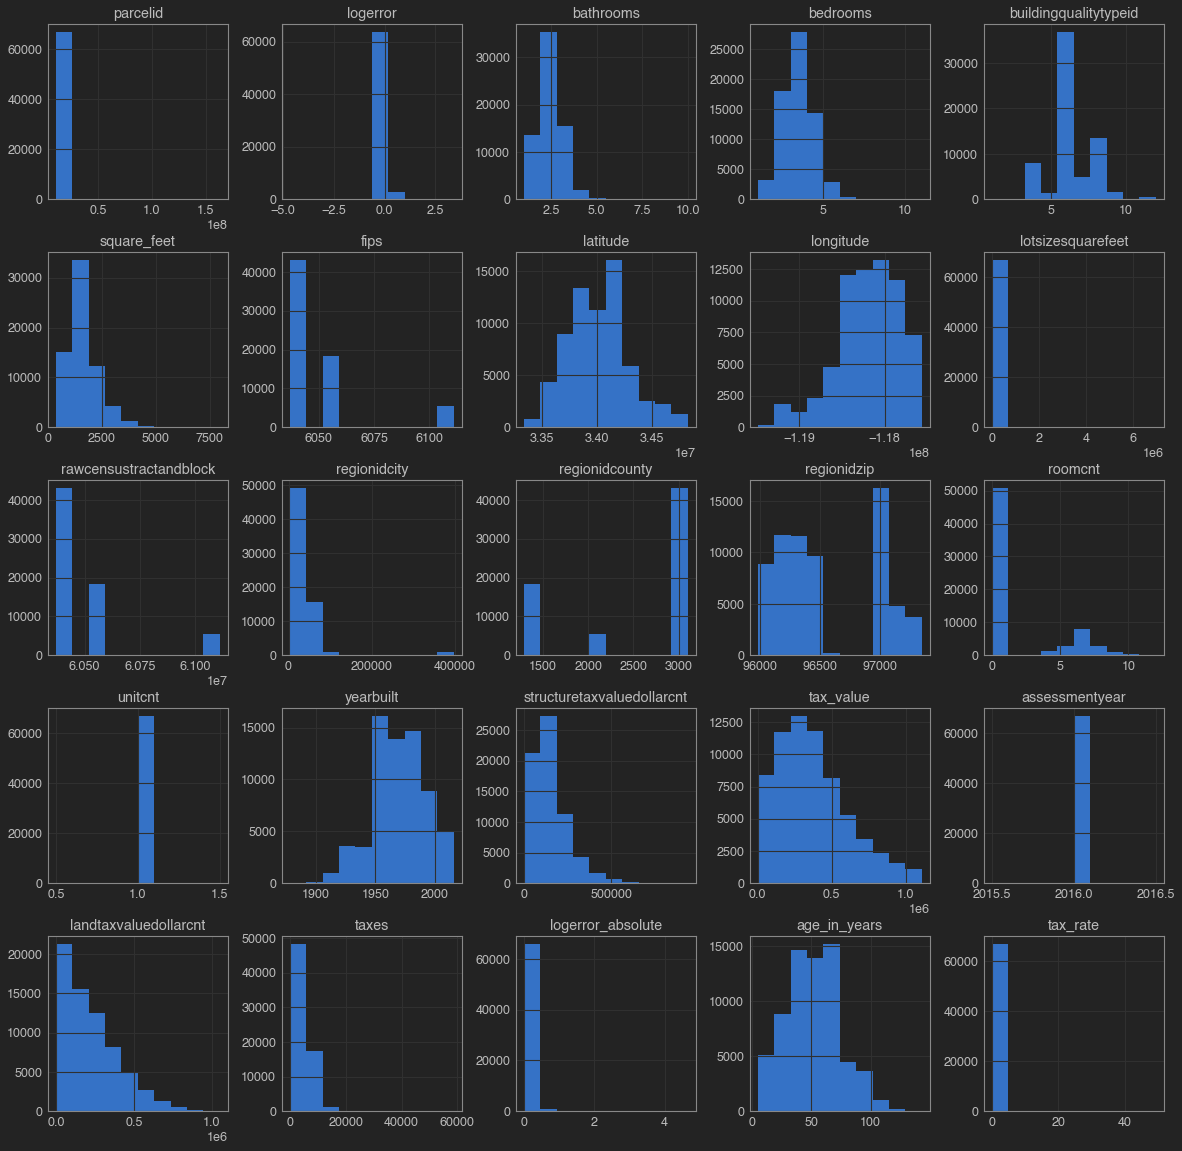

In [3]:
df.hist(figsize=[20,20])

<AxesSubplot:xlabel='logerror_absolute', ylabel='Count'>

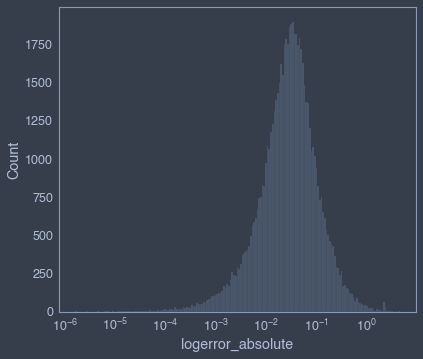

In [4]:
# Displaying a distribution of logerror on the log scale
jtplot.style(theme='onedork',grid=False)
sns.histplot(df['logerror_absolute'], log_scale = True)

In [94]:
df.logerror.describe()

count    66858.000000
mean         0.015853
std          0.160384
min         -4.655420
25%         -0.023532
50%          0.006056
75%          0.036439
max          3.394544
Name: logerror, dtype: float64

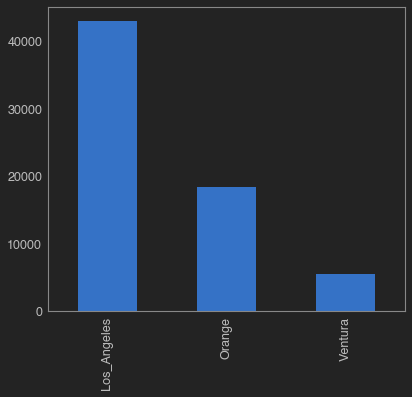

Los_Angeles    0.643124
Orange         0.274702
Ventura        0.082174
Name: county, dtype: float64

In [93]:
jtplot.style(grid=False)
df.county.value_counts().plot.bar()
plt.show()
df.county.value_counts(normalize=True)

In [6]:
df.yearbuilt.describe()

count    66858.000000
mean      1969.113943
std         22.527280
min       1878.000000
25%       1954.000000
50%       1970.000000
75%       1986.000000
max       2016.000000
Name: yearbuilt, dtype: float64

In [7]:
df.age_in_years.describe()

count    66858.000000
mean        51.886057
std         22.527280
min          5.000000
25%         35.000000
50%         51.000000
75%         67.000000
max        143.000000
Name: age_in_years, dtype: float64

In [8]:
#new column for encoding houses built after 1970(median)
df['built_after_1970'] = df.yearbuilt.apply(lambda x: 1 if x >= 1970 else 0)

In [9]:
df.logerror_absolute.describe()

count    66858.000000
mean         0.064940
std          0.147503
min          0.000002
25%          0.013219
50%          0.030295
75%          0.063391
max          4.655420
Name: logerror_absolute, dtype: float64

In [10]:
#creating transaction month column
df['transactiondate'] = df.transactiondate.astype('str')
df['transaction_month'] = df.transactiondate.str.split('-',expand=True)[1]
df.transaction_month.value_counts()

06    9920
05    8968
08    8601
07    8207
03    8030
04    7511
01    6010
02    5483
09    4128
Name: transaction_month, dtype: int64

## Univariate takeaways:
- median yearbuilt is 1970 and median home age is 51
- median absolute log_error is 0.03, max is ~4.7
- 64% of properties are in LA county

In [11]:
#splitting data
train, validate, test = split_zillow(df, stratify_by='county')

In [12]:
train.shape, validate.shape, test.shape

((37440, 32), (16046, 32), (13372, 32))

## 2. How does each variable compare to absolute logerror?

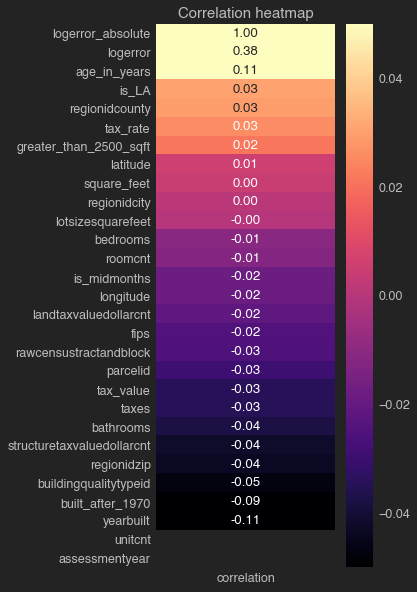

In [91]:
#correlation heatmap
corr = pd.DataFrame(train.corr()['logerror_absolute'].sort_values(ascending = False)).rename(columns = {'logerror_absolute':'correlation'})
jtplot.style()
plt.figure(figsize = (4,10))
sns.heatmap(corr, annot = True, fmt = '.2f', vmin = -0.05, vmax = 0.05, cmap = 'magma')
plt.title('Correlation heatmap', fontsize = 15)
plt.show()

<AxesSubplot:xlabel='county', ylabel='logerror'>

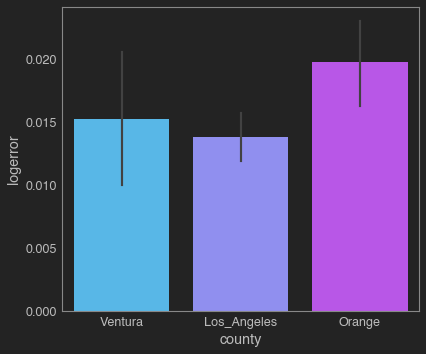

In [14]:
# Displaying the relationship between county and logerror
# Orange county has a significantly higher avereage error than the other counties, although this is average
# including over/under estimates. If we want an idea of total deviation from the true value of the property
# we have to use an absolute error to measure deviations from the true value.
jtplot.style(grid=False)
sns.barplot(x = train['county'], y = train['logerror'], palette='cool')

<AxesSubplot:xlabel='county', ylabel='logerror_absolute'>

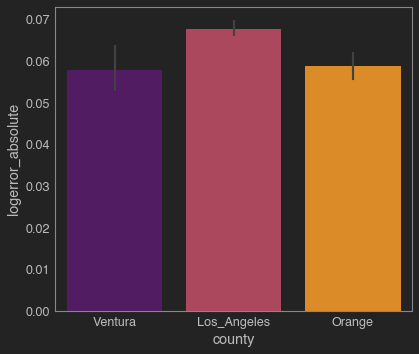

In [15]:
# Displaying the relationship between county and their relative absolute logerror
# Los Angeles seems to have a higher average absolute logerror. So estimates are least reliable when coming
# from LA. While this is useful information for reliability of estimations, as a predictor it doesn't provide
# much insight.

sns.barplot(x = train['county'], y = train['logerror_absolute'],palette='inferno')

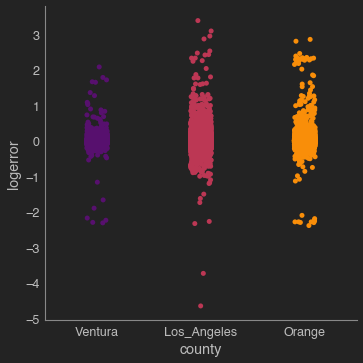

In [16]:
sns.catplot(data=train, x='county',y='logerror', hue='county', palette='inferno')

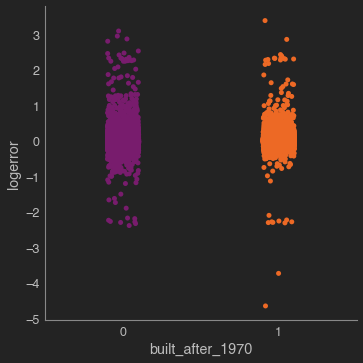

In [17]:
sns.catplot(data=train, x='built_after_1970',y='logerror', hue='built_after_1970', palette='inferno')

<AxesSubplot:xlabel='square_feet', ylabel='logerror'>

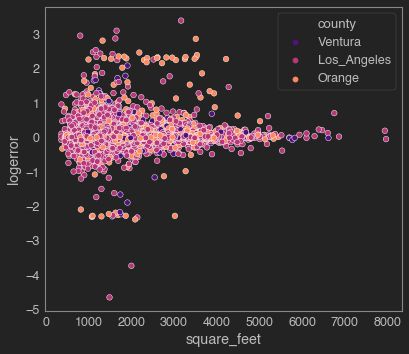

In [18]:
# Displaying relationship between square footage and logerror
# Note as square footage increases total error seems to go down
sns.scatterplot(data=train, x='square_feet',y='logerror', hue='county', palette='magma')

<AxesSubplot:xlabel='tax_value', ylabel='logerror'>

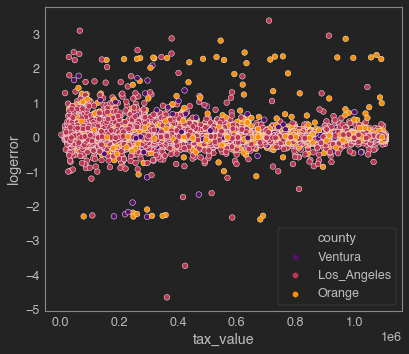

In [19]:
# Displaying relationship between square footage and logerror
# Doesn't seem to be much of a relationship here
sns.scatterplot(data=train, x='tax_value',y='logerror', hue='county', palette='inferno')

<AxesSubplot:xlabel='transaction_month', ylabel='logerror_absolute'>

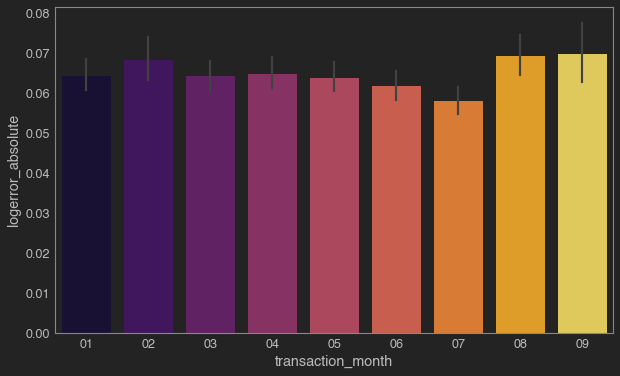

In [20]:
# 
plt.figure(figsize=[10,6])
sns.barplot(data=train, x='transaction_month',y='logerror_absolute', palette='inferno',order=['01','02','03','04','05','06','07','08','09'])

<AxesSubplot:xlabel='buildingqualitytypeid', ylabel='logerror'>

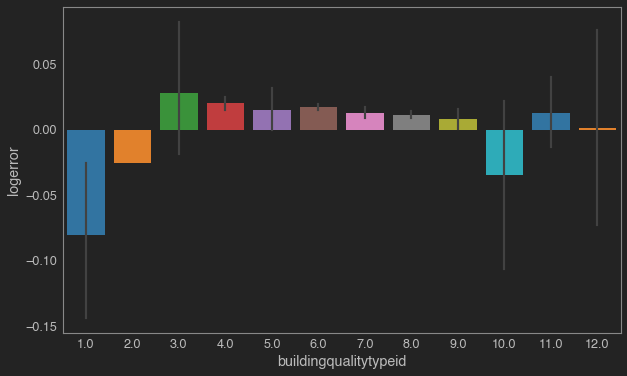

In [21]:
# Displaying relationship between building quality type and logerror
plt.figure(figsize=[10,6])
sns.barplot(x = train['buildingqualitytypeid'], y = train['logerror'],palette='tab10')

## Bivariate/Multivariate takeaways
- Not much correlation to absolute logerror. Best was home age with 0.11 r value
- LA county has a wider range of logerror including a few outliers with less than -3
- Minus a few outliers, homes built after 1970 generally have logerrors with a tighter grouping to 0
- Mean absolute logerror tends to decrease from March to July, August and September transactions had the highest absolute logerrors

## 3. Is the mean absolute log error significantly different between LA and Orange+Ventura county?

<AxesSubplot:xlabel='logerror_absolute', ylabel='Density'>

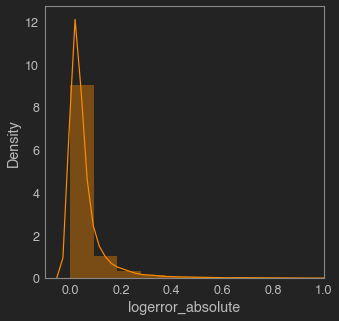

In [22]:
plt.figure(figsize=[5,5])
plt.xlim(-.1,1)
sns.distplot(train.logerror_absolute,color='darkorange')

In [23]:
LA_abslogerror = train[train.county == 'Los_Angeles'].logerror_absolute
Ventura_Orange_abslogerror = train[train.county != 'Los_Angeles'].logerror_absolute

null_hypothesis = "The mean absolute log errors are the same between LA and other counties"
alternative_hypothesis = "The mean absolute log errors are significantly different between LA and other counties"
confidence_level = .95
a = 1 - confidence_level

t, p = stats.ttest_ind(LA_abslogerror, Ventura_Orange_abslogerror)
t, p

(5.946857543085628, 2.7575872188153258e-09)

In [24]:
if p < a:
    print('We reject the null')
    print('The mean absolute log error for LA county is significantly different than Ventura + Orange counties')
else:
    print("we fail to reject the null")

We reject the null
The mean absolute log error for LA county is significantly different than Ventura + Orange counties


In [25]:
LA_abslogerror.mean(), Ventura_Orange_abslogerror.mean()

(0.0678071566156529, 0.0585945006929287)

## 4. Is the mean absolute log error significantly different between homes built pre and post 1970?

<AxesSubplot:xlabel='logerror_absolute', ylabel='Density'>

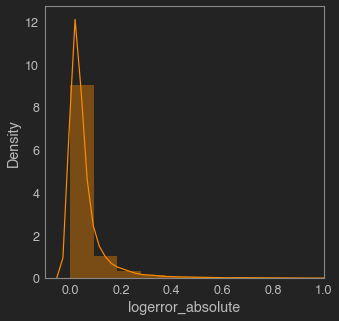

In [26]:
plt.figure(figsize=[5,5])
plt.xlim(-.1,1)
sns.distplot(train.logerror_absolute,color='darkorange')

<AxesSubplot:xlabel='yearbuilt', ylabel='Count'>

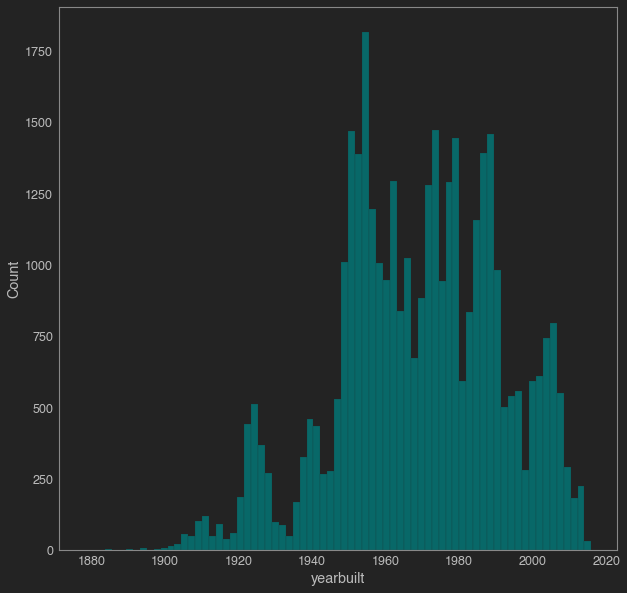

In [27]:
plt.figure(figsize=[10,10])
sns.histplot(train.yearbuilt,color='teal')

<AxesSubplot:xlabel='longitude', ylabel='latitude'>

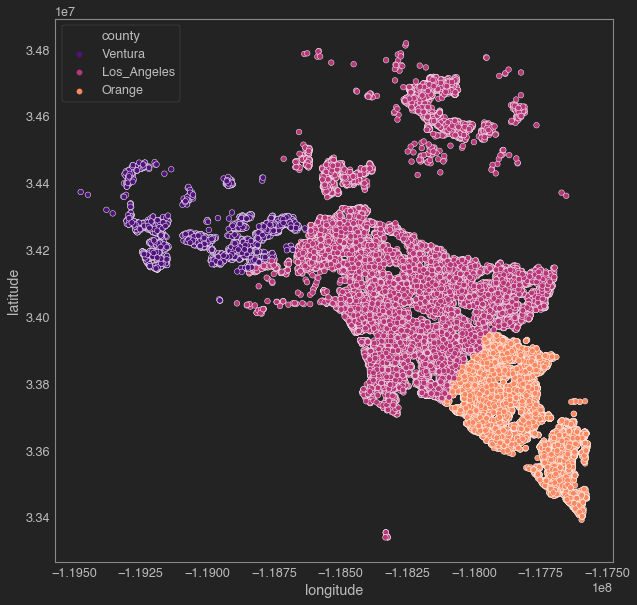

In [28]:
# scattermap to show properties by county
plt.figure(figsize=[10,10])
sns.scatterplot(y=train.latitude , x=train.longitude, hue=train.county, palette='magma')

<AxesSubplot:xlabel='longitude', ylabel='latitude'>

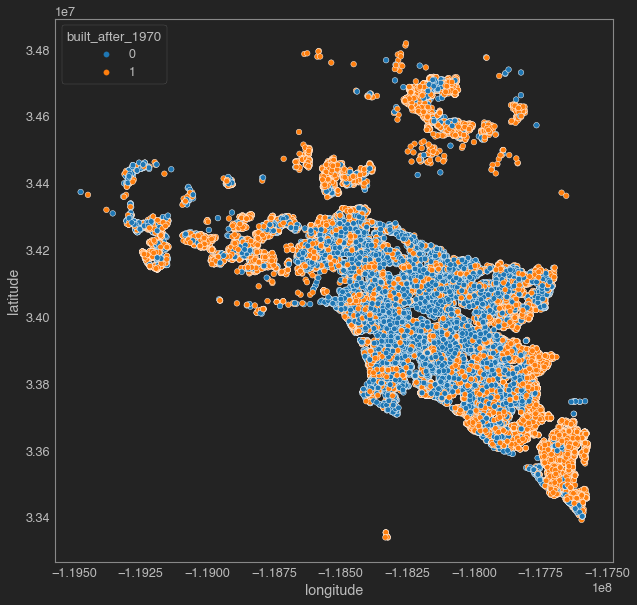

In [29]:
plt.figure(figsize=[10,10])
sns.scatterplot(y=train.latitude , x=train.longitude, hue=train.built_after_1970, palette='tab10')

<AxesSubplot:xlabel='square_feet', ylabel='logerror'>

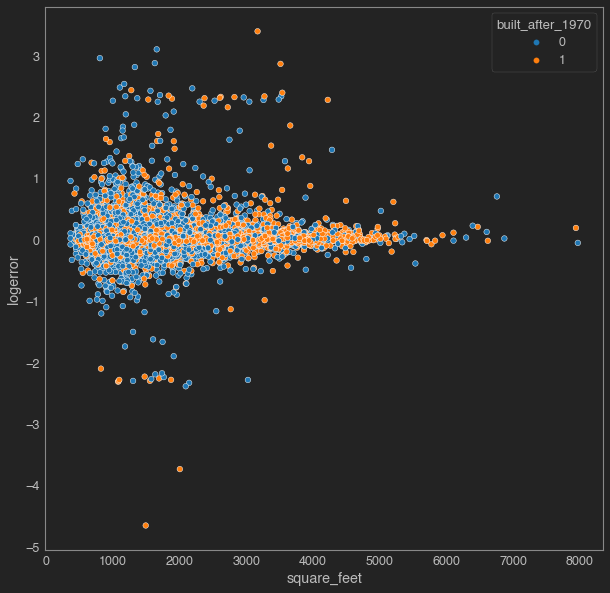

In [30]:
plt.figure(figsize=[10,10])
sns.scatterplot(data=train, x='square_feet',y='logerror', hue='built_after_1970', palette='tab10')

In [31]:
post_1970_abslogerror = train[train.built_after_1970 == 1].logerror_absolute
pre_1970_abslogerror = train[train.built_after_1970 == 0].logerror_absolute

null_hypothesis = "The mean absolute log errors are the same between pre and post 1970"
alternative_hypothesis = "The mean absolute log errors are significantly different between pre and post 1970"
confidence_level = .95
a = 1 - confidence_level

t, p = stats.ttest_ind(pre_1970_abslogerror, post_1970_abslogerror)
t, p

(17.087207826707715, 3.2686417287011712e-65)

In [32]:
if p < a:
    print('We reject the null')
    print('We move forward with the alternative hypothesis acknowledging that the mean absolute log error is significantly different between homes built pre and post 1970')
else:
    print("we fail to reject the null")

We reject the null
We move forward with the alternative hypothesis acknowledging that the mean absolute log error is significantly different between homes built pre and post 1970


In [33]:
pre_1970_abslogerror.mean(), post_1970_abslogerror.mean()

(0.07745633355843484, 0.0521723802684004)

## 5. Is the mean absolute log error significantly different between homes sold March-July vs other months?

<AxesSubplot:xlabel='transaction_month', ylabel='logerror_absolute'>

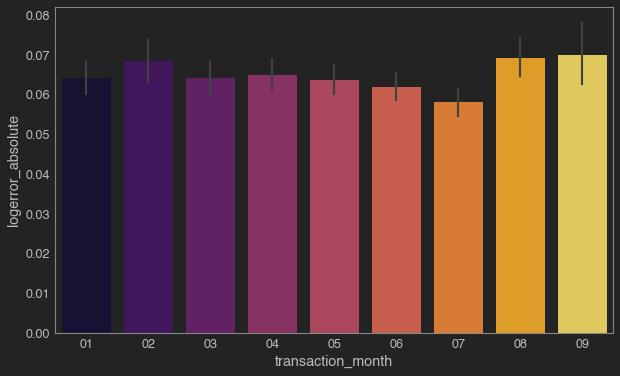

In [34]:
plt.figure(figsize=[10,6])
sns.barplot(data=train, x='transaction_month',y='logerror_absolute', palette='inferno',order=['01','02','03','04','05','06','07','08','09'])

In [35]:
#encoding 1 if county is LA
train['is_LA'] = train.county.apply(lambda x: 1 if x == 'Los_Angeles' else 0)
validate['is_LA'] = validate.county.apply(lambda x: 1 if x == 'Los_Angeles' else 0)
test['is_LA'] = test.county.apply(lambda x: 1 if x == 'Los_Angeles' else 0)

#encoding 1 if March through July
midmonths = ['03','04','05','06','07']
train['is_midmonths'] = train.transaction_month.apply(lambda x: 1 if x in midmonths else 0)
validate['is_midmonths'] = validate.transaction_month.apply(lambda x: 1 if x in midmonths else 0)
test['is_midmonths'] = test.transaction_month.apply(lambda x: 1 if x in midmonths else 0)

In [36]:
midmonth_abslogerror = train[train.is_midmonths == 1].logerror_absolute
othermonth_abslogerror = train[train.is_midmonths == 0].logerror_absolute

null_hypothesis = "The mean absolute log errors are the same between homes sold from March-July and other months"
alternative_hypothesis = "The mean absolute log errors are significantly different between homes sold from March-July and other months"
confidence_level = .95
a = 1 - confidence_level

t, p = stats.ttest_ind(midmonth_abslogerror, othermonth_abslogerror)
t, p

(-3.5232917351909747, 0.00042672967529639583)

In [37]:
if p < a:
    print('We reject the null')
    print('We move forward with the alternative hypothesis acknowledging that the mean absolute log error is significantly different between homes sold from March-July and other months')
else:
    print("we fail to reject the null")

We reject the null
We move forward with the alternative hypothesis acknowledging that the mean absolute log error is significantly different between homes sold from March-July and other months


In [38]:
midmonth_abslogerror.mean(), othermonth_abslogerror.mean()

(0.06254635020892475, 0.06798720785686675)

# Sam's statistical tests:
-------------------------------------

## Test 1
Is there a significant difference in the average error of Orange County and the total average error? (alpha = .05)

In [39]:
x1 = train[train['county'] == 'Orange']
x1 = x1['logerror']
x2 = train.logerror.mean()
t, p = stats.ttest_1samp(x1, x2)

print(f't = {t:.3f}')
print(f'p = {p:.3f}')

t = 2.452
p = 0.014


With a p-value falling below my set alpha, we can reasonably say there is a significant difference in the average logerror between Orange county and the average.

## Test 2
Is there a difference in the average log error between houses that are greater than 2500 feet and those that are less? (alpha = .05)

In [40]:
x1 = train[train['square_feet'] < 2500]
x1 = x1['logerror']
x2 = train[train['square_feet'] > 2500]
x2 = x2['logerror']
t, p = stats.ttest_ind(x1, x2)

print(f't = {t:.3f}')
print(f'p = {p:.3f}')

t = -7.773
p = 0.000


With a p-value falling below my set alpha, we can reasonably say there is a significant difference in the average logerror between properties with greater than 2500 square feet and those with less.

## Test 3
Is there a difference in the average log error between houses that have more than 4 bathrooms and those that have 4 or less? (alpha = .05)

In [41]:
x1 = train[train['bathrooms'] <= 4]
x1 = x1['logerror']
x2 = train[train['square_feet'] > 4]
x2 = x2['logerror']
t, p = stats.ttest_ind(x1, x2)

print(f't = {t:.3f}')
print(f'p = {p:.3f}')

t = -0.301
p = 0.763


With a p-value above my alpha, we can say that there is likely no significant difference in logerror between properties with more than 4 bathrooms and those with 4 or less.

### Adding > 2500 sqft feature

In [42]:
train['greater_than_2500_sqft'] = train.square_feet.apply(lambda x: 1 if x > 2500 else 0)
validate['greater_than_2500_sqft'] = validate.square_feet.apply(lambda x: 1 if x > 2500 else 0)
test['greater_than_2500_sqft'] = test.square_feet.apply(lambda x: 1 if x > 2500 else 0)

# Clustering
---------

In [43]:
features = ['bedrooms',
            'bathrooms',
            'square_feet',
            'lotsizesquarefeet',
            'tax_value',
            'tax_rate',
            'age_in_years',
            'built_after_1970',
            'is_LA',
            'is_midmonths',
            'latitude',
            'longitude'
           ]

X_train = train[features]
y_train = train.logerror

X_validate = validate[features]
y_validate = validate.logerror

X_test = test[features]
y_test = test.logerror

In [44]:
# Scaling data using standard scaler
X_train_scaled, X_validate_scaled, X_test_scaled = scale_data(X_train,X_validate,X_test)
X_train_scaled.head()

,bedrooms,bathrooms,square_feet,lotsizesquarefeet,tax_value,tax_rate,age_in_years,built_after_1970,is_LA,is_midmonths,latitude,longitude
0,0.045562,-0.852878,-0.890545,-0.156188,0.489345,-0.473265,0.318762,-1.023623,-1.342377,0.754248,0.677789,-1.850657
1,1.086346,-0.219399,1.221363,-0.151314,-1.071105,0.381005,0.274273,-1.023623,0.744947,0.754248,0.430286,0.490343
2,1.086346,-0.219399,0.134823,-0.113206,-0.457315,-0.112573,0.452227,-1.023623,0.744947,-1.325823,0.902277,-0.889295
3,-0.995222,-0.219399,-0.453599,-0.178027,0.212718,-0.397330,-0.748966,0.976922,-1.342377,-1.325823,-0.819241,1.112484
4,0.045562,-1.486356,-1.231363,-0.191009,-1.464468,1.349178,1.386489,-1.023623,0.744947,0.754248,-0.214087,-0.180301


----------
## square_feet, 
## tax_value cluster


In [45]:
X = X_train_scaled[['square_feet','tax_value']]

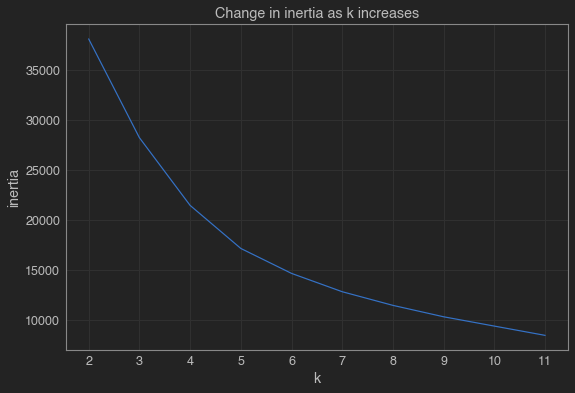

In [46]:
with plt.style.context('seaborn-whitegrid'):
    jtplot.style()
    plt.figure(figsize=(9, 6))
    pd.Series({k: KMeans(k).fit(X).inertia_ for k in range(2, 12)}).plot(marker='x')
    plt.xticks(range(2, 12))
    plt.xlabel('k')
    plt.ylabel('inertia')
    plt.title('Change in inertia as k increases')

In [47]:
#create, fit, predict using kmeans
kmeans = KMeans(n_clusters=5)
kmeans.fit(X)
X_train_scaled['cluster'] = kmeans.predict(X)
X['cluster'] = kmeans.predict(X)
centroids_scaled = pd.DataFrame(kmeans.cluster_centers_, columns = X.iloc[:,0:2].columns)
centroids = X_train_scaled.groupby('cluster')['square_feet', 'tax_value'].mean()

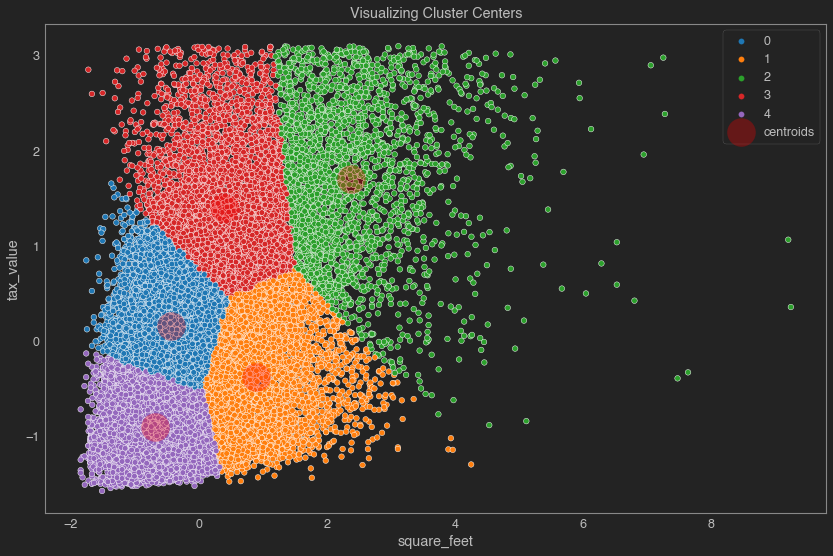

In [48]:
plt.figure(figsize=(14, 9))

# scatter plot of data with hue for cluster
sns.scatterplot(x = 'square_feet', y = 'tax_value', data = X, hue = 'cluster', palette='tab10')

# plot cluster centers (centroids)
centroids.plot.scatter(x = 'square_feet', y = 'tax_value', ax = plt.gca(), color ='red', alpha = 0.3, s = 800, marker = 'o', label = 'centroids')
plt.title('Visualizing Cluster Centers')
plt.legend();

### Cluster descriptions:
    0: Mostly not Orange county, lower square footage, large number of bathrooms
    1: Majority Orange county, lower square footage, average number of bathrooms
    2: Pretty even spread by county, high square footage, high number of bathrooms, high square footage
    3: Mostly not Orange county, lower square footage, small amount of bathrooms
    4:

## Sam Cluster 1 
- 'county_Orange',
- 'bathrooms', 
- 'greater_than_2500_sqft'

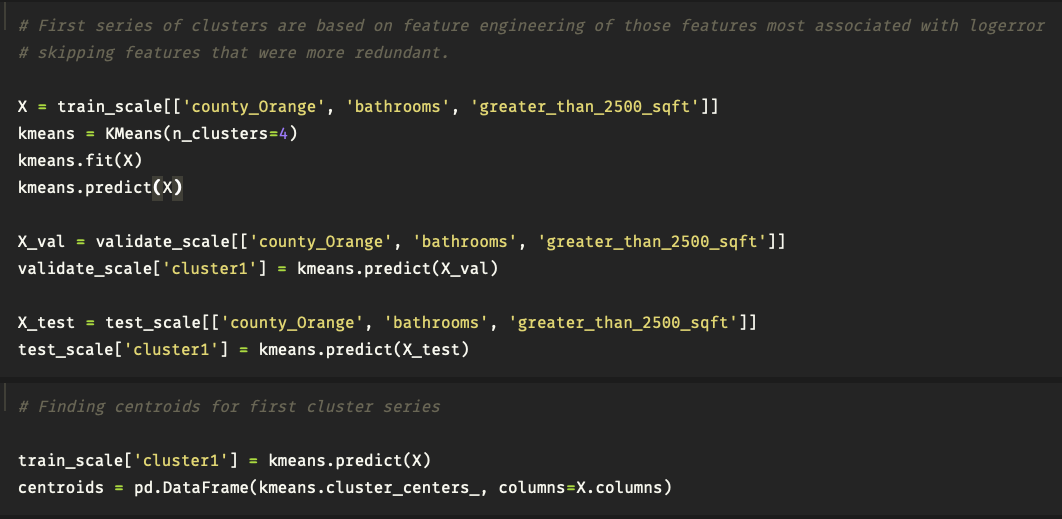

In [49]:
display.Image("./SamCluster1.png")

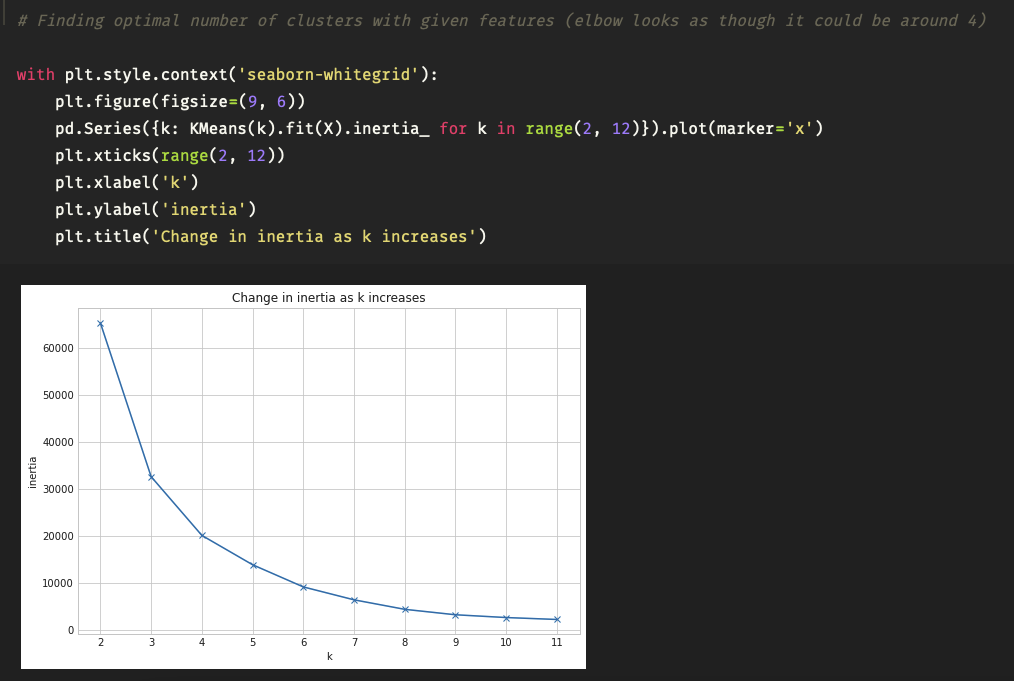

In [50]:
display.Image("./SamCluster2.png")

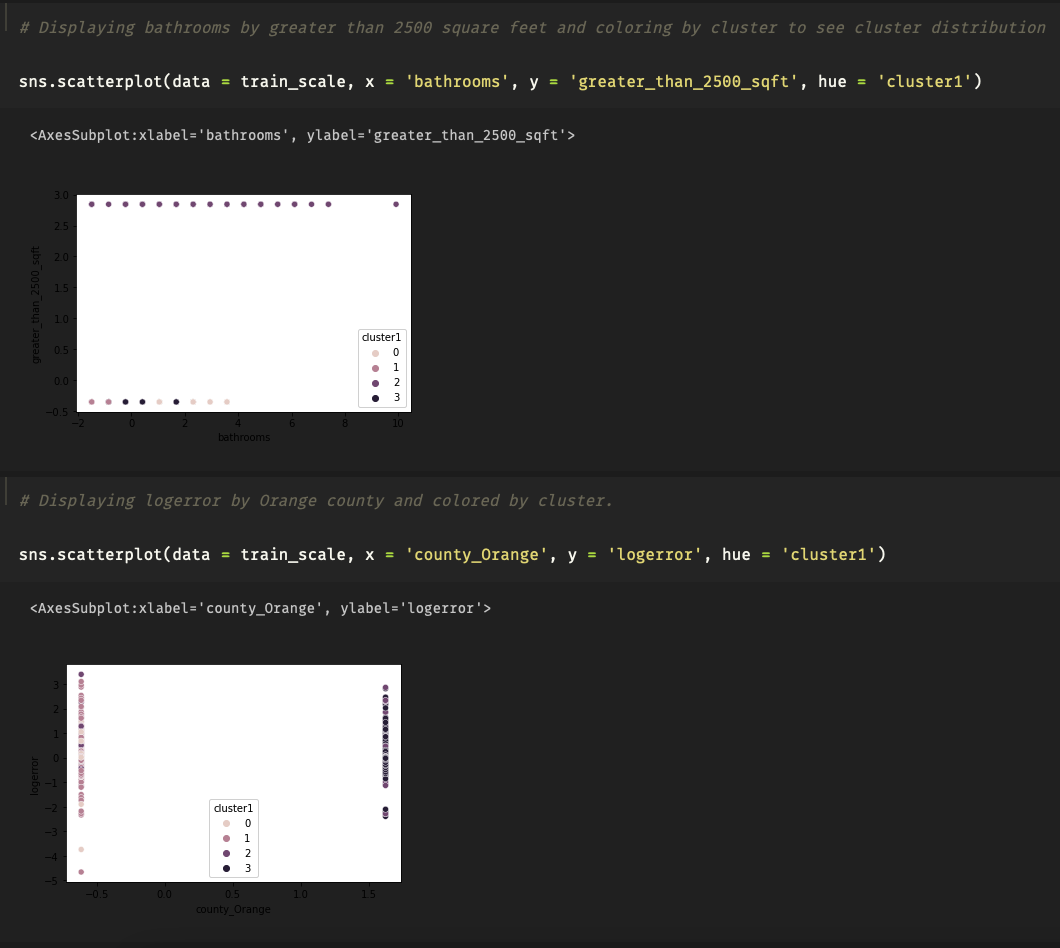

In [51]:
display.Image("./SamCluster3.png")

### The clusters seem to have the following descriptions:
    0: Mostly not Orange county, lower square footage, large number of bathrooms
    1: Majority Orange county, lower square footage, average number of bathrooms
    2: Pretty even spread by county, high square footage, high number of bathrooms, high square footage
    3: Mostly not Orange county, lower square footage, small amount of bathrooms

---------------
# Sam Cluster 2
- tax_rate, 
- age_in_years, 
- square_feet cluster


In [52]:
# clusters created using features that would seem to have no relationship

X = X_train_scaled[['tax_rate', 'age_in_years', 'square_feet']]
kmeans = KMeans(n_clusters=4)
kmeans.fit(X)
kmeans.predict(X)

array([2, 3, 2, ..., 1, 1, 1], dtype=int32)

In [53]:
# Creating centroids
X_train_scaled['cluster2'] = kmeans.predict(X)
centroids = pd.DataFrame(kmeans.cluster_centers_, columns=X.columns)

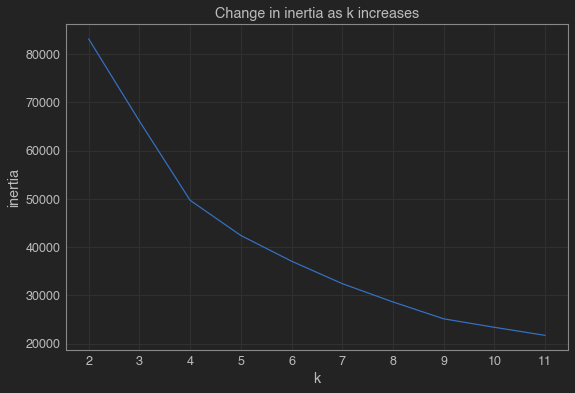

In [54]:
with plt.style.context('seaborn-whitegrid'):
    jtplot.style()
    plt.figure(figsize=(9, 6))
    pd.Series({k: KMeans(k).fit(X).inertia_ for k in range(2, 12)}).plot(marker='x')
    plt.xticks(range(2, 12))
    plt.xlabel('k')
    plt.ylabel('inertia')
    plt.title('Change in inertia as k increases')

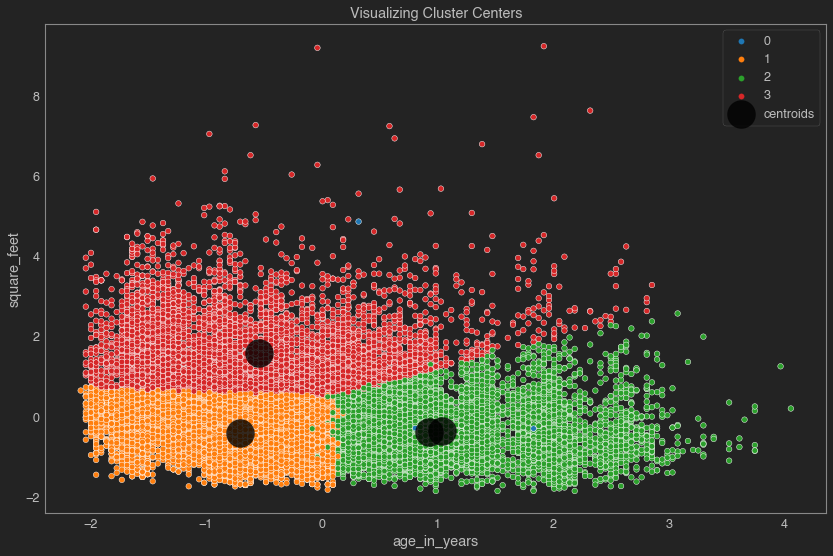

In [55]:
plt.figure(figsize=(14, 9))

# scatter plot of data with hue for cluster
sns.scatterplot(y = 'square_feet', x = 'age_in_years', data = X_train_scaled, hue = 'cluster2', palette='tab10')

# plot cluster centers (centroids)
centroids.plot.scatter(y = 'square_feet', x = 'age_in_years', ax = plt.gca(), color ='black', alpha = 0.8, s = 800, marker = 'o', label = 'centroids')
plt.title('Visualizing Cluster Centers')
plt.legend();

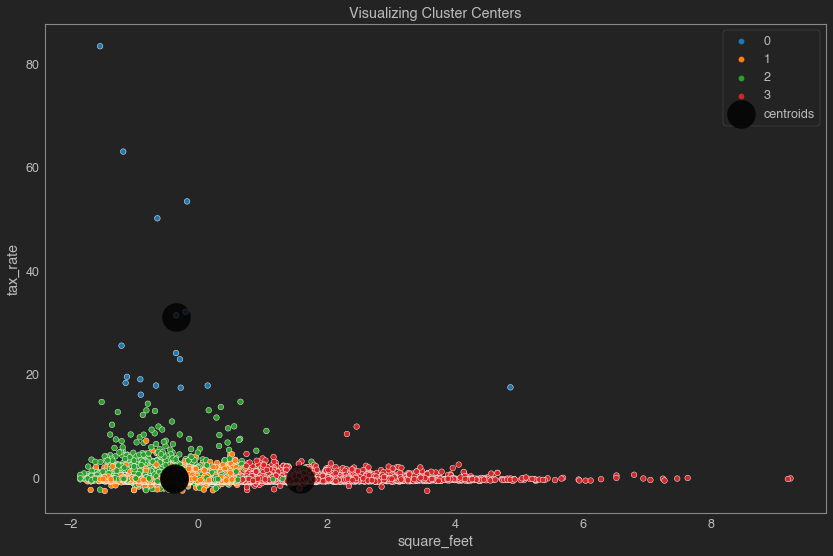

In [56]:
plt.figure(figsize=(14, 9))

# scatter plot of data with hue for cluster
sns.scatterplot(x = 'square_feet', y = 'tax_rate', data = X_train_scaled, hue = 'cluster2', palette='tab10')

# plot cluster centers (centroids)
centroids.plot.scatter(x = 'square_feet', y = 'tax_rate', ax = plt.gca(), color ='black', alpha = 0.8, s = 800, marker = 'o', label = 'centroids')
plt.title('Visualizing Cluster Centers')
plt.legend();

In [57]:
centroids

,tax_rate,age_in_years,square_feet
0,31.210671,1.035814,-0.349074
1,-0.092311,-0.706188,-0.390569
2,0.107932,0.927499,-0.380775
3,-0.114584,-0.538750,1.587184


### Cluster descriptions:
    0: moderate tax rate, old, low square feet
    1: high tax rate, old, low square feet
    2: moderate tax rate, young, high square footage
    3: moderate tax rate, very young, low square feet

--------
## longitude,
## latitude cluster

In [58]:
X = X_train_scaled[['longitude','latitude']]

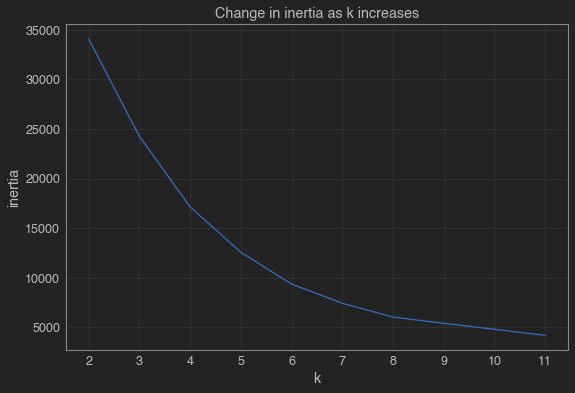

In [59]:
with plt.style.context('seaborn-whitegrid'):
    jtplot.style()
    plt.figure(figsize=(9, 6))
    pd.Series({k: KMeans(k).fit(X).inertia_ for k in range(2, 12)}).plot(marker='x')
    plt.xticks(range(2, 12))
    plt.xlabel('k')
    plt.ylabel('inertia')
    plt.title('Change in inertia as k increases')

In [60]:
kmeans = KMeans(n_clusters=6, random_state=123)
kmeans.fit(X)
X_train_scaled['cluster'] = kmeans.predict(X)
X['cluster'] = kmeans.predict(X)
centroids_scaled = pd.DataFrame(kmeans.cluster_centers_, columns = X.iloc[:,0:2].columns)
centroids = X_train_scaled.groupby('cluster')['longitude', 'latitude'].mean()

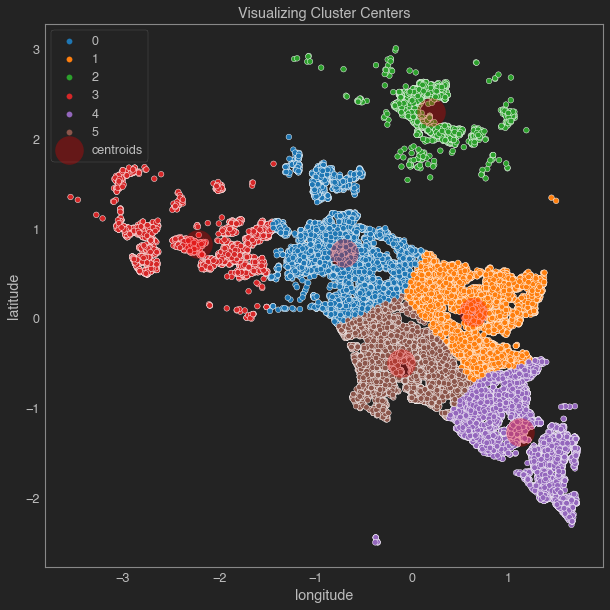

In [61]:
plt.figure(figsize=(10, 10))

# scatter plot of data with hue for cluster
sns.scatterplot(x = 'longitude', y = 'latitude', data = X_train_scaled, hue = 'cluster', palette='tab10')

# plot cluster centers (centroids)
centroids.plot.scatter(x = 'longitude', y = 'latitude', ax = plt.gca(), color ='red', alpha = 0.3, s = 800, marker = 'o', label = 'centroids')

plt.title('Visualizing Cluster Centers')
plt.legend();

### Cluster descriptions:
    0: West LA
    1: East LA
    2: North LA
    3: Ventura
    4: Orange
    5: SouthWest LA

## Clustering takeaways
- clustering by region makes the most sense
- LA is split into 4 regions, Ventura and Orange county are their own clusters

------
# Regression Modeling

In [62]:
#narrowing down features for modeling based on prior experience with data set and stats testing
features = ['bedrooms',
            'bathrooms',
            'square_feet',
            'lotsizesquarefeet',
            'tax_value',
            'tax_rate',
            'age_in_years',
            'built_after_1970',
            'is_LA',
            'is_midmonths',
            'latitude',
            'longitude'
           ]

X_train = train[features]
y_train = train.logerror

X_validate = validate[features]
y_validate = validate.logerror

X_test = test[features]
y_test = test.logerror

In [63]:
#converting series to dataframes
y_train= pd.DataFrame(y_train)
y_validate = pd.DataFrame(y_validate)
y_test = pd.DataFrame(y_test)

In [64]:
X_train_scaled, X_validate_scaled, X_test_scaled = scale_data(X_train,X_validate,X_test)
X_train_scaled.head()

,bedrooms,bathrooms,square_feet,lotsizesquarefeet,tax_value,tax_rate,age_in_years,built_after_1970,is_LA,is_midmonths,latitude,longitude
0,0.045562,-0.852878,-0.890545,-0.156188,0.489345,-0.473265,0.318762,-1.023623,-1.342377,0.754248,0.677789,-1.850657
1,1.086346,-0.219399,1.221363,-0.151314,-1.071105,0.381005,0.274273,-1.023623,0.744947,0.754248,0.430286,0.490343
2,1.086346,-0.219399,0.134823,-0.113206,-0.457315,-0.112573,0.452227,-1.023623,0.744947,-1.325823,0.902277,-0.889295
3,-0.995222,-0.219399,-0.453599,-0.178027,0.212718,-0.397330,-0.748966,0.976922,-1.342377,-1.325823,-0.819241,1.112484
4,0.045562,-1.486356,-1.231363,-0.191009,-1.464468,1.349178,1.386489,-1.023623,0.744947,0.754248,-0.214087,-0.180301


### Feature engineering
- using select kbest and rfe for guidelines on which features to focus on

In [65]:
feature_train = train.select_dtypes(include=['float64', 'int64', 'uint8'])
select_kbest(feature_train.drop(columns=['logerror']), feature_train['logerror'], 5)

['bathrooms',
 'bedrooms',
 'square_feet',
 'logerror_absolute',
 'greater_than_2500_sqft']

In [66]:
select_kbest(X_train_scaled,y_train, 8)

['bedrooms',
 'bathrooms',
 'square_feet',
 'tax_rate',
 'is_LA',
 'is_midmonths',
 'latitude',
 'longitude']

In [67]:
rfe(X_train_scaled, y_train, 8)

['bedrooms',
 'square_feet',
 'lotsizesquarefeet',
 'tax_value',
 'tax_rate',
 'built_after_1970',
 'is_midmonths',
 'latitude']

In [68]:
#Fitting kmeans to latitude, longitude clusters
X = X_train_scaled[['longitude','latitude']]
kmeans = KMeans(n_clusters=6, random_state=123)
kmeans.fit(X)

KMeans(n_clusters=6, random_state=123)

In [69]:
#adding cluster columns to train, validate, test
X_train_scaled['cluster'] = kmeans.predict(X)
y_train['cluster'] = kmeans.predict(X)

X_validate_scaled['cluster'] = kmeans.predict(X_validate_scaled[['longitude','latitude']])
y_validate['cluster'] = kmeans.predict(X_validate_scaled[['longitude','latitude']])

X_test_scaled['cluster'] = kmeans.predict(X_test_scaled[['longitude','latitude']])
y_test['cluster'] =  kmeans.predict(X_test_scaled[['longitude','latitude']])

In [70]:
X_train_scaled.head(1)

,bedrooms,bathrooms,square_feet,lotsizesquarefeet,tax_value,tax_rate,age_in_years,built_after_1970,is_LA,is_midmonths,latitude,longitude,cluster
0,0.045562,-0.852878,-0.890545,-0.156188,0.489345,-0.473265,0.318762,-1.023623,-1.342377,0.754248,0.677789,-1.850657,3


## Sam Cluster 1 
- 'county_Orange',
- 'bathrooms', 
- 'greater_than_2500_sqft'

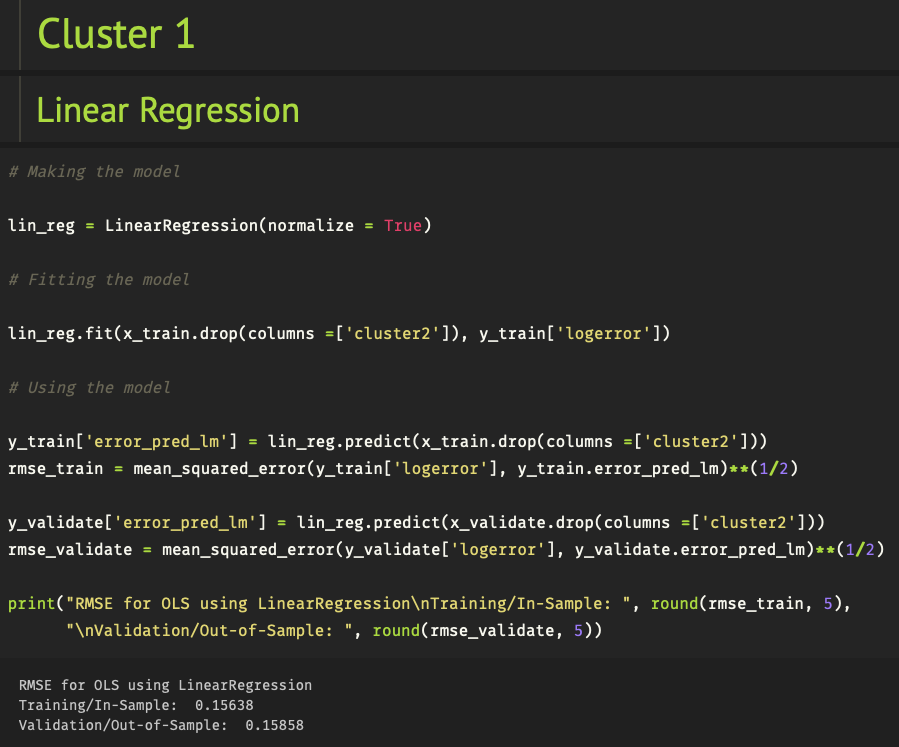

In [71]:
display.Image("./Sam Linear model train.png")

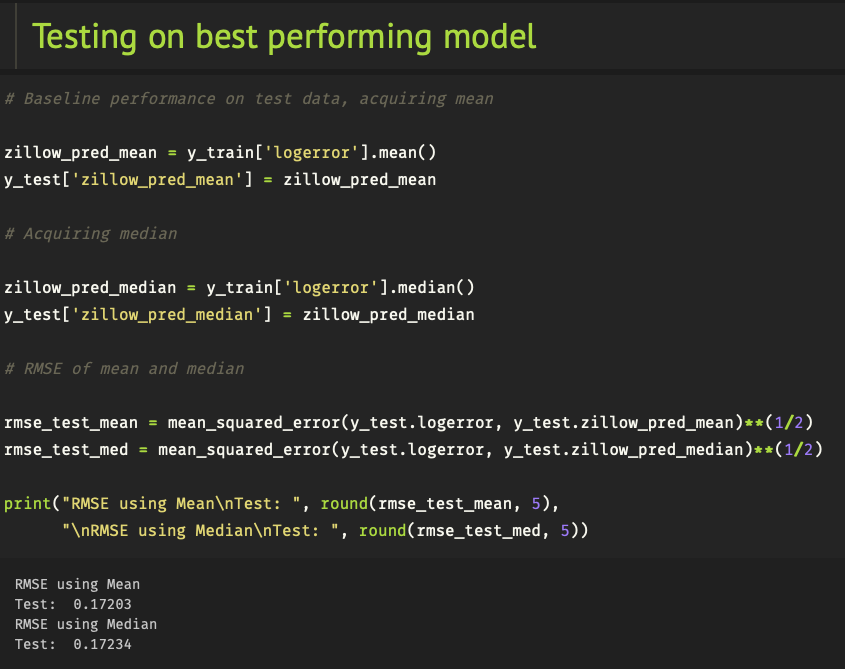

In [72]:
display.Image("./Sam Linear model test.png")

# subsetting train, validate, test with latitude, longitude Clusters

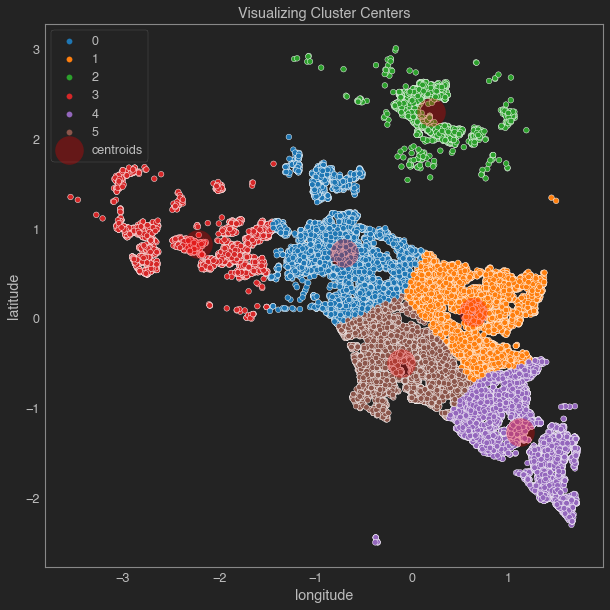

In [73]:
plt.figure(figsize=(10, 10))
# scatter plot of data with hue for cluster
sns.scatterplot(x = 'longitude', y = 'latitude', data = X_train_scaled, hue = 'cluster', palette='tab10')

# plot cluster centers (centroids)
centroids.plot.scatter(x = 'longitude', y = 'latitude', ax = plt.gca(), color ='red', alpha = 0.3, s = 800, marker = 'o', label = 'centroids')
plt.title('Visualizing Cluster Centers')
plt.legend();

### Cluster descriptions:
    0: West LA
    1: East LA
    2: North LA
    3: Ventura
    4: Orange
    5: SouthWest LA

In [74]:
X_train_scaled.cluster.value_counts()

0    8994
4    8048
5    7994
1    7307
3    3059
2    2038
Name: cluster, dtype: int64

In [75]:
# subsetting train for west LA
X_train_scaled_West_LA = X_train_scaled[X_train_scaled.cluster == 0]
y_train_West_LA = y_train[y_train.cluster == 0]

In [76]:
# subsetting validate for west LA
X_validate_scaled_West_LA = X_validate_scaled[X_validate_scaled.cluster == 0]
y_validate_West_LA = y_validate[y_validate.cluster == 0]

In [77]:
# subsetting test for west LA
X_test_scaled_West_LA = X_test_scaled[X_test_scaled.cluster == 0]
y_test_West_LA = y_test[y_test.cluster == 0]

------
# Baseline RMSE 0.13 (mean) - West LA cluster (0)

In [78]:
#mean baseline
logerror_pred_mean = y_train_West_LA.logerror.mean()
y_train_West_LA['logerror_pred_mean'] = logerror_pred_mean
y_validate_West_LA['logerror_pred_mean'] = logerror_pred_mean

In [79]:
#median baseline
logerror_pred_median = y_train_West_LA.logerror.median()
y_train_West_LA['logerror_pred_median'] = logerror_pred_median
y_validate_West_LA['logerror_pred_median'] = logerror_pred_median

In [80]:
#RMSE of pred_mean
rmse_train = mean_squared_error(y_train_West_LA.logerror, y_train_West_LA.logerror_pred_mean) ** .5
rmse_validate = mean_squared_error(y_validate_West_LA.logerror, y_validate_West_LA.logerror_pred_mean) ** (1/2)

print("RMSE using Mean\nTrain/In-Sample: ", round(rmse_train, 2), 
      "\nValidate/Out-of-Sample: ", round(rmse_validate, 2))
print()

#RMSE of pred_median
rmse_train = mean_squared_error(y_train_West_LA.logerror, y_train_West_LA.logerror_pred_median) ** .5
rmse_validate = mean_squared_error(y_validate_West_LA.logerror, y_validate_West_LA.logerror_pred_median) ** .5
print("RMSE using Median\nTrain/In-Sample: ", round(rmse_train, 2), 
      "\nValidate/Out-of-Sample: ", round(rmse_validate, 2))

RMSE using Mean
Train/In-Sample:  0.15 
Validate/Out-of-Sample:  0.13

RMSE using Median
Train/In-Sample:  0.15 
Validate/Out-of-Sample:  0.13


-------
# Gradient Boost Regressor

In [81]:
from sklearn import ensemble
from sklearn.ensemble import GradientBoostingRegressor

In [82]:
gbr = ensemble.GradientBoostingRegressor(random_state=123, alpha=0.9, criterion='friedman_mse', init=None,
                                         learning_rate=0.03, loss='ls', max_depth=4, max_features=None,
                                         max_leaf_nodes=None, min_impurity_split=1e-07,
                                         min_samples_leaf=1, min_samples_split=2,
                                         min_weight_fraction_leaf=0.0, n_estimators=111,
                                         presort='auto', subsample=1.0, verbose=0,
                                         warm_start=False)

In [83]:
#specifying features for xgb model
gbr_features = ['bedrooms',
                'bathrooms',
                'square_feet',
                'lotsizesquarefeet',
                'tax_value',
                'tax_rate',
                'age_in_years',
                'built_after_1970',
                'is_LA',
                'is_midmonths'
                ]

In [84]:
gbr.fit(X_train_scaled_West_LA[gbr_features], y_train_West_LA.logerror)

GradientBoostingRegressor(learning_rate=0.03, max_depth=4,
                          min_impurity_split=1e-07, n_estimators=111,
                          presort='auto', random_state=123)

In [85]:
# predict train
y_train_West_LA['logerror_pred_gbr'] = gbr.predict(X_train_scaled_West_LA[gbr_features])

# evaluate: rmse
rmse_train = mean_squared_error(y_train_West_LA.logerror, y_train_West_LA.logerror_pred_gbr) ** (1/2)

# predict validate
y_validate_West_LA['logerror_pred_gbr'] = gbr.predict(X_validate_scaled_West_LA[gbr_features])

# evaluate: rmse
rmse_validate = mean_squared_error(y_validate_West_LA.logerror, y_validate_West_LA.logerror_pred_gbr) ** (1/2)

print("RMSE for GBR\nTraining/In-Sample: ", round(rmse_train,2), 
      "\nValidation/Out-of-Sample: ", round(rmse_validate,2))

RMSE for GBR
Training/In-Sample:  0.14 
Validation/Out-of-Sample:  0.13


### GBR model feature rankings

In [86]:
feature_labels = np.array(X_train_scaled_West_LA.columns.tolist())
importance = gbr.feature_importances_
feature_indexes_by_importance = importance.argsort()

for index in feature_indexes_by_importance:
    print('{}-{:.2f}%'.format(feature_labels[index], (importance[index] *100.0)))

is_LA-0.00%
built_after_1970-0.05%
bathrooms-0.36%
is_midmonths-1.52%
bedrooms-5.68%
tax_rate-7.66%
age_in_years-7.72%
lotsizesquarefeet-13.05%
square_feet-28.98%
tax_value-34.98%


# GBR model performance on test data

In [88]:
# predict on test
y_test_West_LA['logerror_pred_gbr'] = gbr.predict(X_test_scaled_West_LA[gbr_features])

# evaluate: rmse
rmse_test = mean_squared_error(y_test_West_LA.logerror, y_test_West_LA.logerror_pred_gbr)**(1/2)

print("RMSE for GBR Model\nOut-of-Sample Performance: ", round(rmse_test,2))

RMSE for GBR Model
Out-of-Sample Performance:  0.17


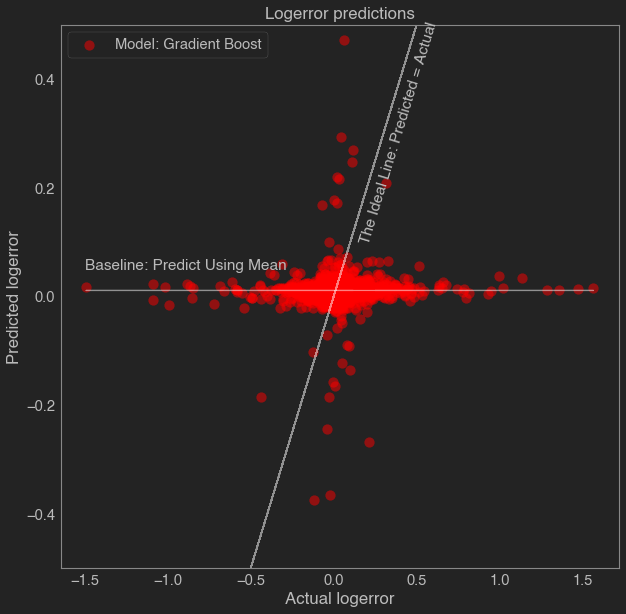

In [89]:
jtplot.style(grid='False', fscale=1.4)
plt.figure(figsize=(10,10))
plt.plot(y_validate_West_LA.logerror, y_validate_West_LA.logerror_pred_mean, alpha=.5, color="white", label='_nolegend_')
plt.annotate("Baseline: Predict Using Mean", (-1.5,.05))
plt.plot(y_validate_West_LA.logerror, y_validate_West_LA.logerror, alpha=.5, color="white", label='_nolegend_')
plt.annotate("The Ideal Line: Predicted = Actual", (.15, .1), rotation=73)

plt.scatter(y_validate_West_LA.logerror, y_validate_West_LA.logerror_pred_gbr, 
            alpha=.5, color="red", s=100, label="Model: Gradient Boost")
plt.ylim(-0.5,0.5)
plt.legend()
plt.xlabel("Actual logerror")
plt.ylabel("Predicted logerror")
plt.title("Logerror predictions")

plt.show()

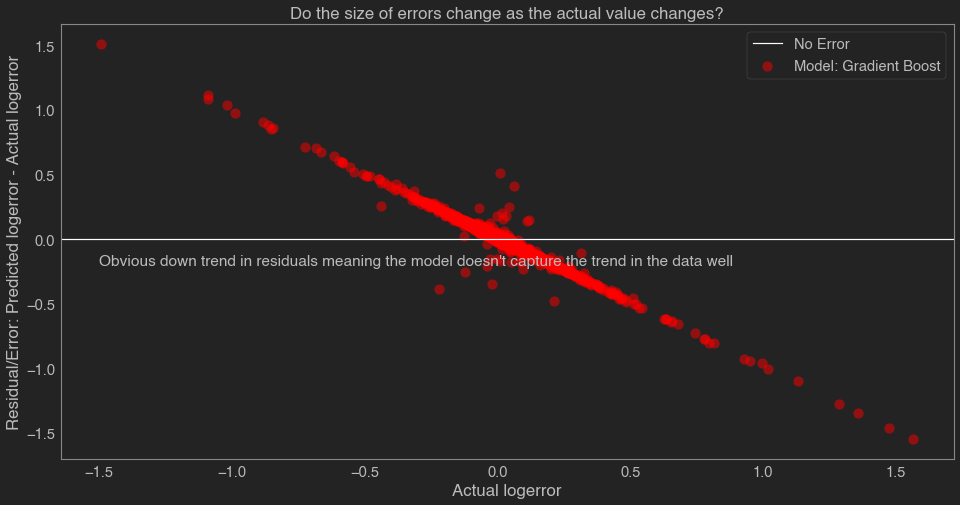

In [90]:
plt.figure(figsize=(16,8))
plt.axhline(label="No Error")
plt.scatter(y_validate_West_LA.logerror, y_validate_West_LA.logerror_pred_gbr-y_validate_West_LA.logerror, 
            alpha=.5, color="red", s=100, label="Model: Gradient Boost")

plt.legend()
plt.xlabel("Actual logerror")
plt.ylabel("Residual/Error: Predicted logerror - Actual logerror")
plt.title("Do the size of errors change as the actual value changes?")
plt.annotate("Obvious down trend in residuals meaning the model doesn't capture the trend in the data well", (-1.5,-0.2))

plt.show()

## Modeling takeaways
- Unable to create model that outperforms baseline
- Features had no linear correlation to logerror

# Conclusions
- logerror is not linear therefore we need nonlinear regression models
- Clustering did not improve linear regression models
- Next steps, possibly get Zestimate and Sale price data or create a logarithmic regression model